In [1]:
import pandas as pd
import numpy as np

    Файлы:

olist_customers_datase.csv — таблица с уникальными идентификаторами пользователей

    customer_id — позаказный идентификатор пользователя
    customer_unique_id —  уникальный идентификатор пользователя  (аналог номера паспорта)
    customer_zip_code_prefix —  почтовый индекс пользователя
    customer_city —  город доставки пользователя
    customer_state —  штат доставки пользователя
    
olist_orders_dataset.csv —  таблица заказов

    order_id —  уникальный идентификатор заказа (номер чека)
    customer_id —  позаказный идентификатор пользователя
    order_status —  статус заказа
    order_purchase_timestamp —  время создания заказа
    order_approved_at —  время подтверждения оплаты заказа
    order_delivered_carrier_date —  время передачи заказа в логистическую службу
    order_delivered_customer_date —  время доставки заказа
    order_estimated_delivery_date —  обещанная дата доставки

olist_order_items_dataset.csv —  товарные позиции, входящие в заказы

    order_id —  уникальный идентификатор заказа (номер чека)
    order_item_id —  идентификатор товара внутри одного заказа
    product_id —  ид товара (аналог штрихкода)
    seller_id — ид производителя товара
    shipping_limit_date —  максимальная дата доставки продавцом для передачи заказа партнеру по логистике
    price —  цена за единицу товара
    freight_value —  вес товара

    — Пример структуры данных можно визуализировать по order_id == 00143d0f86d6fbd9f9b38ab440ac16f5

Уникальные статусы заказов в таблице olist_orders_dataset:

    created —  создан
    approved —  подтверждён
    invoiced —  выставлен счёт
    processing —  в процессе сборки заказа
    shipped —  отгружен со склада
    delivered —  доставлен пользователю
    unavailable —  недоступен
    canceled —  отменён

Для решения задачи проведём предварительное исследование данных и сформулируем, что должно считаться покупкой. 

In [2]:
# path = '/mnt/HC_Volume_18315164/home-jupyter/'
path = ''
file1 = 'olist_customers_dataset.csv'
file2 = 'olist_orders_dataset.csv'
file3 = 'olist_order_items_dataset.csv'

In [3]:
customers = pd.read_csv(path + file1)
orders = pd.read_csv(path + file2, parse_dates=[3,4,5,6,7])
order_items = pd.read_csv(path + file3, parse_dates=[4])

#### Предварительное исследование данных

In [4]:
customers.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP


In [172]:
customers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 5 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   customer_id               99441 non-null  object
 1   customer_unique_id        99441 non-null  object
 2   customer_zip_code_prefix  99441 non-null  int64 
 3   customer_city             99441 non-null  object
 4   customer_state            99441 non-null  object
dtypes: int64(1), object(4)
memory usage: 3.8+ MB


In [173]:
customers.isna().sum()   # проверить

customer_id                 0
customer_unique_id          0
customer_zip_code_prefix    0
customer_city               0
customer_state              0
dtype: int64

In [174]:
# уникальные покупатели, количество
customers.customer_unique_id.nunique()

96096

In [175]:
# таблица с заказами
orders.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26


In [176]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   order_id                       99441 non-null  object        
 1   customer_id                    99441 non-null  object        
 2   order_status                   99441 non-null  object        
 3   order_purchase_timestamp       99441 non-null  datetime64[ns]
 4   order_approved_at              99281 non-null  datetime64[ns]
 5   order_delivered_carrier_date   97658 non-null  datetime64[ns]
 6   order_delivered_customer_date  96476 non-null  datetime64[ns]
 7   order_estimated_delivery_date  99441 non-null  datetime64[ns]
dtypes: datetime64[ns](5), object(3)
memory usage: 6.1+ MB


In [177]:
orders.isna().sum()   # проверить

order_id                            0
customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_approved_at                 160
order_delivered_carrier_date     1783
order_delivered_customer_date    2965
order_estimated_delivery_date       0
dtype: int64

In [178]:
#  заменить NaN на 0 
# orders.fillna(0, inplace=True)

In [179]:
# все чеки уникальны

orders.order_id.nunique()

99441

In [180]:
# какие есть статусы:
orders.groupby('order_status').agg({'order_status': 'value_counts'})

,,order_status
order_status,order_status,
approved,approved,2
canceled,canceled,625
created,created,5
delivered,delivered,96478
invoiced,invoiced,314
processing,processing,301
shipped,shipped,1107
unavailable,unavailable,609


In [181]:
# элементы заказа
order_items.head()

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14


In [182]:
order_items.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112650 entries, 0 to 112649
Data columns (total 7 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   order_id             112650 non-null  object        
 1   order_item_id        112650 non-null  int64         
 2   product_id           112650 non-null  object        
 3   seller_id            112650 non-null  object        
 4   shipping_limit_date  112650 non-null  datetime64[ns]
 5   price                112650 non-null  float64       
 6   freight_value        112650 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(1), object(3)
memory usage: 6.0+ MB


In [183]:
# уникальные чеки  order_items.order_id не полностью совпадают с  orders.order_id
order_items.order_id.nunique()

98666

In [184]:
# максимальное количество позиций в чеке (каком-либо, номер пока не важен, дубликаты тоже не удалял)
order_items['order_item_id'].sort_values().tail()

11950    19
11951    20
75122    20
57316    20
57317    21
Name: order_item_id, dtype: int64

In [185]:
# чек в котором больше всего позиций
order_items.query('order_item_id == 21').order_id

57317    8272b63d03f5f79c56e9e4120aec44ef
Name: order_id, dtype: object

In [186]:
order_items.query('order_id == "8272b63d03f5f79c56e9e4120aec44ef"').tail()

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
57313,8272b63d03f5f79c56e9e4120aec44ef,17,270516a3f41dc035aa87d220228f844c,2709af9587499e95e803a6498a5a56e9,2017-07-21 18:25:23,1.2,7.89
57314,8272b63d03f5f79c56e9e4120aec44ef,18,270516a3f41dc035aa87d220228f844c,2709af9587499e95e803a6498a5a56e9,2017-07-21 18:25:23,1.2,7.89
57315,8272b63d03f5f79c56e9e4120aec44ef,19,270516a3f41dc035aa87d220228f844c,2709af9587499e95e803a6498a5a56e9,2017-07-21 18:25:23,1.2,7.89
57316,8272b63d03f5f79c56e9e4120aec44ef,20,270516a3f41dc035aa87d220228f844c,2709af9587499e95e803a6498a5a56e9,2017-07-21 18:25:23,1.2,7.89
57317,8272b63d03f5f79c56e9e4120aec44ef,21,79ce45dbc2ea29b22b5a261bbb7b7ee7,2709af9587499e95e803a6498a5a56e9,2017-07-21 18:25:23,7.8,6.57


In [187]:
order_items.product_id.nunique()

32951

#### Что будем считать покупкой? варианты: 
    
    - заказ оплачен (order_approved_at != 0 —  время подтверждения оплаты заказа)
    - заказ доставлен (order_status == "delivered")
    

In [188]:
# всего 2 "approved"(подтверждён)  в котором нет "date передачи в доставку" и "date доставки"

# order_approved_at —  время подтверждения оплаты заказа
# order_status —  статус заказа

orders.query('order_status == "approved"')

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
44897,a2e4c44360b4a57bdff22f3a4630c173,8886130db0ea6e9e70ba0b03d7c0d286,approved,2017-02-06 20:18:17,2017-02-06 20:30:19,NaT,NaT,2017-03-01
88457,132f1e724165a07f6362532bfb97486e,b2191912d8ad6eac2e4dc3b6e1459515,approved,2017-04-25 01:25:34,2017-04-30 20:32:41,NaT,NaT,2017-05-22


In [189]:
# есть отказы после оплаты ?  Есть, много 
# order_approved_at != 0

orders.query('order_status == "canceled" and order_approved_at != "NaN"').shape

(484, 8)

In [190]:
# есть отказы после доставки ? - Есть, но МАЛО... 6

orders.query('order_status == "canceled" and order_delivered_customer_date != "NaN"')

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
2921,1950d777989f6a877539f53795b4c3c3,1bccb206de9f0f25adc6871a1bcf77b2,canceled,2018-02-19 19:48:52,2018-02-19 20:56:05,2018-02-20 19:57:13,2018-03-21 22:03:51,2018-03-09
8791,dabf2b0e35b423f94618bf965fcb7514,5cdec0bb8cbdf53ffc8fdc212cd247c6,canceled,2016-10-09 00:56:52,2016-10-09 13:36:58,2016-10-13 13:36:59,2016-10-16 14:36:59,2016-11-30
58266,770d331c84e5b214bd9dc70a10b829d0,6c57e6119369185e575b36712766b0ef,canceled,2016-10-07 14:52:30,2016-10-07 15:07:10,2016-10-11 15:07:11,2016-10-14 15:07:11,2016-11-29
59332,8beb59392e21af5eb9547ae1a9938d06,bf609b5741f71697f65ce3852c5d2623,canceled,2016-10-08 20:17:50,2016-10-09 14:34:30,2016-10-14 22:45:26,2016-10-19 18:47:43,2016-11-30
92636,65d1e226dfaeb8cdc42f665422522d14,70fc57eeae292675927697fe03ad3ff5,canceled,2016-10-03 21:01:41,2016-10-04 10:18:57,2016-10-25 12:14:28,2016-11-08 10:58:34,2016-11-25
94399,2c45c33d2f9cb8ff8b1c86cc28c11c30,de4caa97afa80c8eeac2ff4c8da5b72e,canceled,2016-10-09 15:39:56,2016-10-10 10:40:49,2016-10-14 10:40:50,2016-11-09 14:53:50,2016-12-08


In [191]:
#  другие статусы после оплаты (если ещё не доставлено), тоже МНОГО вариантов

orders.query('order_approved_at != "NaN" and order_status != "delivered"') \
        .groupby('order_status')\
        .agg({'order_status': 'value_counts'})

,,order_status
order_status,order_status,
approved,approved,2
canceled,canceled,484
invoiced,invoiced,314
processing,processing,301
shipped,shipped,1107
unavailable,unavailable,609


In [192]:
orders.query('order_approved_at != "NaN" and order_delivered_customer_date == "NaN"').shape

(2819, 8)

In [193]:
# смотрим кол-во отргуженных заказов  (order_status == "shipped"), т.е. еще в пути

orders.query('order_status == "shipped"').shape

(1107, 8)

In [194]:
# смотрим заказы переданные на отгрузку и не доставленные

orders.query('order_delivered_carrier_date != "NaN" and order_delivered_customer_date == "NaN"').shape

(1183, 8)

In [195]:
# чем различаются эти 1183 - 1107 = 76 строк ??

x = orders.query('order_status == "shipped"')
y = orders.query('order_delivered_carrier_date != "NaN" and order_delivered_customer_date == "NaN"')

In [196]:
z = pd.concat([x,y]).drop_duplicates(keep=False)

In [197]:
# в них есть статус "доставлено"(хоть и нет даты доставки!) и "отменен"=69

z.groupby('order_status').agg({'order_status': 'value_counts'})

,,order_status
order_status,order_status,
canceled,canceled,69
delivered,delivered,7


In [198]:
# Статус "отгружен со склада" может "висеть" ОЧЕНЬ долго... и так и не быть доставленым...

orders.query('order_status == "shipped"').order_delivered_carrier_date.min()

Timestamp('2016-10-11 16:12:23')

In [199]:
orders.query('order_delivered_customer_date != "NaN"').order_delivered_customer_date.max()

Timestamp('2018-10-17 13:22:46')

In [200]:
# сколько может длиться доставка... и так и не прийти: order_status == "shipped", а не "delivered"
# date.max() - потому что так и не доставлено:  order_status == "shipped"
(orders.query('order_delivered_customer_date != "NaN"').order_delivered_customer_date.max() - \
        orders.query('order_status == "shipped"').order_delivered_carrier_date).dt.days.sort_values(ascending=False)

32371    735
18535    732
22948    732
4541     729
34523    721
        ... 
38209     54
24944     54
29651     53
22575     50
62360     42
Name: order_delivered_carrier_date, Length: 1107, dtype: int64

<AxesSubplot:>

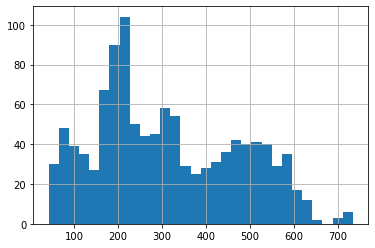

In [201]:
(orders.query('order_delivered_customer_date != "NaN"').order_delivered_customer_date.max() - \
        orders.query('order_status == "shipped"').order_delivered_carrier_date)\
        .dt.days.sort_values(ascending=False).hist(bins=30)

In [202]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   order_id                       99441 non-null  object        
 1   customer_id                    99441 non-null  object        
 2   order_status                   99441 non-null  object        
 3   order_purchase_timestamp       99441 non-null  datetime64[ns]
 4   order_approved_at              99281 non-null  datetime64[ns]
 5   order_delivered_carrier_date   97658 non-null  datetime64[ns]
 6   order_delivered_customer_date  96476 non-null  datetime64[ns]
 7   order_estimated_delivery_date  99441 non-null  datetime64[ns]
dtypes: datetime64[ns](5), object(3)
memory usage: 6.1+ MB


In [203]:
orders['delivery_time'] = orders['order_delivered_customer_date'] - orders['order_delivered_carrier_date']

<AxesSubplot:>

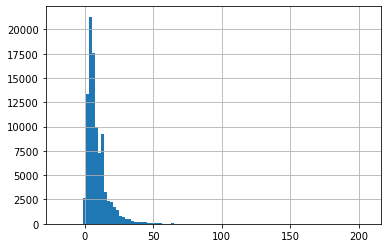

In [204]:
orders['delivery_time'].dt.days.hist(bins=100)

In [205]:
# order_delivered_customer_date —  время доставки заказа, и статус доставлено
# отличаются НЕ сильно (возможно просто потереялись даты)

orders.query('order_delivered_customer_date != "NaN"').shape

(96476, 9)

In [206]:
orders.query('order_status == "delivered"').shape

(96478, 9)

 Всё-таки: **считаем покупкой статус "оплата подтверждена"** (order_approved_at != "NaN"). С причиной отказов нужно разбираться отдельно. А между Доставлено и Оплачено более 2000 покупок которые в принципе могут быть доставлены позже (и от них не отказались).

 #### 1. Сколько у нас пользователей, которые совершили покупку только один раз? 

In [207]:
# первый вариант смерджить к customers чеки,  сгруппировать 

In [208]:
cust_unique_order_id = customers[['customer_id','customer_unique_id']] \
                        .merge(orders.drop(columns=['order_purchase_timestamp', \
                                        'delivery_time', \
                                        'order_delivered_carrier_date', \
                                        'order_delivered_customer_date', \
                                        'order_estimated_delivery_date']),\
                           on='customer_id',how='inner')

In [209]:
cust_unique_order_id.head()

,customer_id,customer_unique_id,order_id,order_status,order_approved_at
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,00e7ee1b050b8499577073aeb2a297a1,delivered,2017-05-16 15:22:12
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,29150127e6685892b6eab3eec79f59c7,delivered,2018-01-12 20:58:32
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,b2059ed67ce144a36e2aa97d2c9e9ad2,delivered,2018-05-20 16:19:10
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,951670f92359f4fe4a63112aa7306eba,delivered,2018-03-13 17:29:19
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,6b7d50bd145f6fc7f33cebabd7e49d0f,delivered,2018-07-29 10:10:09


In [210]:
# общее кол-во строк не изменилось
cust_unique_order_id.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 99441 entries, 0 to 99440
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   customer_id         99441 non-null  object        
 1   customer_unique_id  99441 non-null  object        
 2   order_id            99441 non-null  object        
 3   order_status        99441 non-null  object        
 4   order_approved_at   99281 non-null  datetime64[ns]
dtypes: datetime64[ns](1), object(4)
memory usage: 4.6+ MB


In [211]:
cust_unique_order_id.isna().sum()   # проверить

customer_id             0
customer_unique_id      0
order_id                0
order_status            0
order_approved_at     160
dtype: int64

In [212]:
# уникальных пользователей не потеряли
cust_unique_order_id.customer_unique_id.nunique()

96096

In [213]:
# выбираем совершенные покупки   == "order_approved_at != "NaN""
cust_unique_order_id.query('order_approved_at != "NaN"', inplace=True)

In [214]:
# группируем уникальные ID и считаем кол-во  чеков у каждого. выбираем те ID где 1 покупка

cust_unique_order_id.groupby('customer_unique_id') \
                    .agg({'order_id':'count'}) \
                    .query('order_id == 1').sum()

order_id    93049
dtype: int64

#### Получилось, что  93049  (~ 97% из 96096) покупателей сделали покупку 1 раз.

#### 2. Сколько заказов в месяц в среднем не доставляется по разным причинам (вывести детализацию по причинам)?

    order_status —  статус заказа
    order_purchase_timestamp —  время создания заказа
    order_approved_at —  время подтверждения оплаты заказа
    order_delivered_carrier_date —  время передачи заказа в логистическую службу
    order_delivered_customer_date —  время доставки заказа

In [215]:
# будем считать, что заказ относится к месяцу в котором он сделан (order_purchase_timestamp)

orders.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,delivery_time
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,6 days 01:30:13
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,12 days 00:56:45
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,9 days 04:16:29
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15,9 days 10:48:43
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26,1 days 22:30:28


In [216]:
orders['purchase_month'] = orders['order_purchase_timestamp'].dt.strftime("%Y-%m")

In [217]:
# сделаем таблицу "не доставлено"
not_delivered = orders.query('order_status in ("canceled","unavailable")')

In [218]:
#  группируем по году и месяцу
not_delivered.groupby(['purchase_month']) \
             .agg({'order_status':'count'}).head()

,order_status
purchase_month,
2016-09,2
2016-10,31
2017-01,13
2017-02,62
2017-03,65


In [219]:
# 2 вариант
# not_delivered_2 = orders.query('order_status != "delivered"')

In [220]:
#  группируем по году и месяцу
# not_delivered.groupby(['purchase_year','purchase_month']) \
#             .agg({'order_status':'count'}).head()

KeyError: 'purchase_year'

In [221]:
not_delivered.groupby(['purchase_month']) \
             .agg({'order_status':'count'}).mean()

order_status    51.416667
dtype: float64

####   51.4  заказа в среднем не доставляется в течение месяца

In [222]:
#  из-за "Отказа"
not_delivered.query('order_status == "canceled"').groupby(['purchase_month']) \
             .agg({'order_status':'count'}).mean()

order_status    26.041667
dtype: float64

In [223]:
# из-за "Недоступности"
not_delivered.query('order_status == "unavailable"').groupby(['purchase_month']) \
             .agg({'order_status':'count'}).mean()

order_status    29.0
dtype: float64

In [224]:
# посмотрим причины по месяцам
not_delivered.groupby(['purchase_month']).agg({'order_status':'value_counts'}).tail()

order_status
purchase_month order_status              
2018-07        unavailable             18
2018-08        canceled                84
               unavailable              7
2018-09        canceled                15
2018-10        canceled                 4

In [225]:
not_delivered.agg({'order_status':'value_counts'})

,order_status
canceled,625
unavailable,609


#### За всё время не доставлено:
    
    
    отменены (canceled)          625
    недоступны? (unavailable)    609
   

<AxesSubplot:xlabel='purchase_month', ylabel='unavailable'>

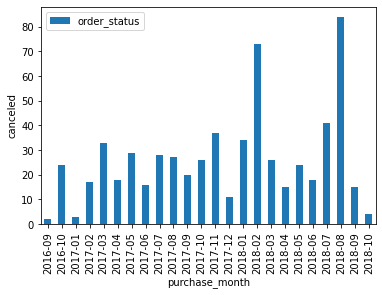

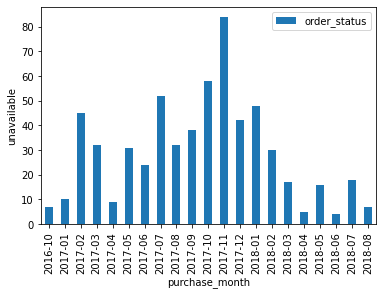

In [226]:
not_delivered.query('order_status == "canceled"').groupby(['purchase_month']) \
             .agg({'order_status':'count'}).plot(kind='bar', ylabel='canceled')
not_delivered.query('order_status == "unavailable"').groupby(['purchase_month']) \
             .agg({'order_status':'count'}).plot(kind='bar', ylabel='unavailable')

#### 3. По каждому товару определить, в какой день недели товар чаще всего покупается.

In [ ]:
# выбираем совершенные покупки   == "order_approved_at != "NaN""
# query('order_approved_at != "NaN"')

In [227]:
orders.query('order_approved_at != "NaN"').order_id.nunique()

99281

In [228]:
day_purchase = order_items[['order_id', 'order_item_id', 'product_id']].merge(orders, how='left')

In [229]:
day_purchase.query('order_approved_at != "NaN"').order_id.nunique()

98652

Как и раньше не совпадает с таблицей чеков (orders).

In [230]:
day_purchase.head()

,order_id,order_item_id,product_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,delivery_time,purchase_month
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,3ce436f183e68e07877b285a838db11a,delivered,2017-09-13 08:59:02,2017-09-13 09:45:35,2017-09-19 18:34:16,2017-09-20 23:43:48,2017-09-29,1 days 05:09:32,2017-09
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,f6dd3ec061db4e3987629fe6b26e5cce,delivered,2017-04-26 10:53:06,2017-04-26 11:05:13,2017-05-04 14:35:00,2017-05-12 16:04:24,2017-05-15,8 days 01:29:24,2017-04
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,6489ae5e4333f3693df5ad4372dab6d3,delivered,2018-01-14 14:33:31,2018-01-14 14:48:30,2018-01-16 12:36:48,2018-01-22 13:19:16,2018-02-05,6 days 00:42:28,2018-01
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,d4eb9395c8c0431ee92fce09860c5a06,delivered,2018-08-08 10:00:35,2018-08-08 10:10:18,2018-08-10 13:28:00,2018-08-14 13:32:39,2018-08-20,4 days 00:04:39,2018-08
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,58dbd0b2d70206bf40e62cd34e84d795,delivered,2017-02-04 13:57:51,2017-02-04 14:10:13,2017-02-16 09:46:09,2017-03-01 16:42:31,2017-03-17,13 days 06:56:22,2017-02


In [231]:
#  добавим колонку  день недели покупки
day_purchase['day'] = day_purchase['order_approved_at'].dt.strftime('%A')

In [232]:
#  сделаем новую таблицу с количеством покупок каждого товара в каждый день недели

count_day = day_purchase.groupby(['product_id', 'day'],as_index=False) \
                        .agg(count_day=('day','size'))\
                        .sort_values('count_day', ascending=False)

In [233]:
count_day.head()

,product_id,day,count_day
41082,aca2eb7d00ea1a7b8ebd4e68314663af,Tuesday,119
20152,53b36df67ebb7c41585e8d54d6772e08,Tuesday,105
41077,aca2eb7d00ea1a7b8ebd4e68314663af,Friday,96
15933,422879e10f46682990de24d770e7f83d,Tuesday,89
41083,aca2eb7d00ea1a7b8ebd4e68314663af,Wednesday,89


In [234]:
count_day.shape

(61143, 3)

In [235]:
#   посчитаем количество уникальных товаров
count_day.product_id.nunique()

32948

In [236]:
# для каждого товара оставим только дни с их максимальным количеством покупок

count_day.drop_duplicates(subset=['product_id'], keep='first')

,product_id,day,count_day
41082,aca2eb7d00ea1a7b8ebd4e68314663af,Tuesday,119
20152,53b36df67ebb7c41585e8d54d6772e08,Tuesday,105
15933,422879e10f46682990de24d770e7f83d,Tuesday,89
36574,99a4788cb24856965c36a24e339b6058,Tuesday,82
13060,368c6c730842d78016ad823897a372db,Thursday,80
...,...,...,...
23976,63dfa8b12200610ed7b5e41d3c888a25,Saturday,1
23980,63e51e65ec59b56039c6427eed73dcf0,Tuesday,1
23981,63eb97106bfe47fe857edcf78f3e3e08,Saturday,1
23991,63f52009dc3ddb733394e80183aed0f0,Saturday,1


In [64]:
#    количество строк таблицы совпадает с количеством уникальных товаров. Никого не потеряли.

###  4. Сколько у каждого из пользователей в среднем покупок в неделю (по месяцам)? Не стоит забывать, что внутри месяца может быть не целое количество недель. Например, в ноябре 2021 года 4,28 недели. И внутри метрики это нужно учесть.

In [65]:
customers.customer_id.nunique()

99441

In [66]:
customers.columns

Index(['customer_id', 'customer_unique_id', 'customer_zip_code_prefix',
       'customer_city', 'customer_state'],
      dtype='object')

In [67]:
orders.customer_id.nunique()

99441

In [68]:
orders.columns

Index(['order_id', 'customer_id', 'order_status', 'order_purchase_timestamp',
       'order_approved_at', 'order_delivered_carrier_date',
       'order_delivered_customer_date', 'order_estimated_delivery_date',
       'purchase_year', 'purchase_month'],
      dtype='object')

In [69]:
#   объединим таблицы покупатели и чеки (нужные колонки)
#   будем считать, что заказ относится к месяцу в котором он сделан (order_purchase_timestamp)

cust_orders = pd.merge(customers.drop(columns=['customer_zip_code_prefix', \
                                               'customer_city', \
                                               'customer_state']), 
                       orders.drop(columns=['order_approved_at', \
                                            'order_delivered_carrier_date', \
                                            'order_delivered_customer_date', \
                                            'order_estimated_delivery_date']), 
                       on = ['customer_id'])

In [70]:
cust_orders.head()


,customer_id,customer_unique_id,order_id,order_status,order_purchase_timestamp,purchase_year,purchase_month
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,00e7ee1b050b8499577073aeb2a297a1,delivered,2017-05-16 15:05:35,2017,5
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,29150127e6685892b6eab3eec79f59c7,delivered,2018-01-12 20:48:24,2018,1
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,b2059ed67ce144a36e2aa97d2c9e9ad2,delivered,2018-05-19 16:07:45,2018,5
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,951670f92359f4fe4a63112aa7306eba,delivered,2018-03-13 16:06:38,2018,3
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,6b7d50bd145f6fc7f33cebabd7e49d0f,delivered,2018-07-29 09:51:30,2018,7


In [71]:
# ничего не потеряли
cust_orders.shape

(99441, 7)

In [72]:
# считаем кол-во недель в месяце


In [73]:
cust_orders['month_name'] = cust_orders.order_purchase_timestamp.dt.month_name()

In [74]:
cust_orders['week_in_month'] = cust_orders.order_purchase_timestamp.dt.days_in_month / 7

In [75]:
cust_orders.head()

,customer_id,customer_unique_id,order_id,order_status,order_purchase_timestamp,purchase_year,purchase_month,month_name,week_in_month
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,00e7ee1b050b8499577073aeb2a297a1,delivered,2017-05-16 15:05:35,2017,5,May,4.428571
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,29150127e6685892b6eab3eec79f59c7,delivered,2018-01-12 20:48:24,2018,1,January,4.428571
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,b2059ed67ce144a36e2aa97d2c9e9ad2,delivered,2018-05-19 16:07:45,2018,5,May,4.428571
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,951670f92359f4fe4a63112aa7306eba,delivered,2018-03-13 16:06:38,2018,3,March,4.428571
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,6b7d50bd145f6fc7f33cebabd7e49d0f,delivered,2018-07-29 09:51:30,2018,7,July,4.428571


In [76]:
# выбираем  совершённые  покупки
cust_orders = cust_orders.query('order_status == "delivered"')

In [77]:
cust_orders.shape

(96478, 9)

In [78]:
#   у большинства покупателей всего одна покупка за весь период...
#   еще одна таблица: с количеством покупок в конкретный месяц каждым покупателем

count_week = cust_orders.groupby(['customer_unique_id', 'month_name', 'week_in_month'], as_index=False) \
                        .agg(count_order_In_month= ('month_name','count')) \
                        .sort_values('count_order_In_month',ascending=False)

In [79]:
count_week.head()

,customer_unique_id,month_name,week_in_month,count_order_In_month
7097,12f5d6e1cbf93dafd9dcc19095df0b3d,January,4.428571,6
67329,b4e4f24de1e8725b74e4a1f4975116ed,February,4.000000,4
65740,b08fab27d47a1eb6deda07bfd965ad43,September,4.285714,4
14053,25a560b9a6006157838aab1bdbd68624,April,4.285714,4
23212,3e43e6105506432c953e165fb2acf44c,February,4.000000,4


In [80]:
count_week['order_in_week'] = count_week.count_order_In_month / count_week.week_in_month

In [81]:
# количество покупок в неделю

count_week.head()

,customer_unique_id,month_name,week_in_month,count_order_In_month,order_in_week
7097,12f5d6e1cbf93dafd9dcc19095df0b3d,January,4.428571,6,1.354839
67329,b4e4f24de1e8725b74e4a1f4975116ed,February,4.000000,4,1.000000
65740,b08fab27d47a1eb6deda07bfd965ad43,September,4.285714,4,0.933333
14053,25a560b9a6006157838aab1bdbd68624,April,4.285714,4,0.933333
23212,3e43e6105506432c953e165fb2acf44c,February,4.000000,4,1.000000


###   5. Используя pandas, проведи когортный анализ пользователей. В период с января по декабрь выяви когорту с самым высоким retention на 3й месяц.

с января по декабрь только 2017 год...
Retention на 3й месяц ~ процент покупателей которые, сделав первую покупку (допустим в январе),
вернулись и сделали повторную покупку через 3 месяца (апрель)

In [82]:
#   объединим таблицы покупатели и чеки (нужные колонки)
#   будем считать, что заказ относится к месяцу в котором он сделан (order_purchase_timestamp)

cust_orders = pd.merge(customers.drop(columns=['customer_zip_code_prefix', \
                                               'customer_city', \
                                               'customer_state']), 
                       orders.drop(columns=['order_approved_at', \
                                            'order_delivered_carrier_date', \
                                            'order_delivered_customer_date', \
                                            'order_estimated_delivery_date']), 
                       on = ['customer_id'])

In [83]:
#  воспользуемся таблицей с прошлого шага: пользователи и дата заказа
cust_orders

,customer_id,customer_unique_id,order_id,order_status,order_purchase_timestamp,purchase_year,purchase_month
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,00e7ee1b050b8499577073aeb2a297a1,delivered,2017-05-16 15:05:35,2017,5
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,29150127e6685892b6eab3eec79f59c7,delivered,2018-01-12 20:48:24,2018,1
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,b2059ed67ce144a36e2aa97d2c9e9ad2,delivered,2018-05-19 16:07:45,2018,5
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,951670f92359f4fe4a63112aa7306eba,delivered,2018-03-13 16:06:38,2018,3
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,6b7d50bd145f6fc7f33cebabd7e49d0f,delivered,2018-07-29 09:51:30,2018,7
...,...,...,...,...,...,...,...
99436,17ddf5dd5d51696bb3d7c6291687be6f,1a29b476fee25c95fbafc67c5ac95cf8,6760e20addcf0121e9d58f2f1ff14298,delivered,2018-04-07 15:48:17,2018,4
99437,e7b71a9017aa05c9a7fd292d714858e8,d52a67c98be1cf6a5c84435bd38d095d,9ec0c8947d973db4f4e8dcf1fbfa8f1b,delivered,2018-04-04 08:20:22,2018,4
99438,5e28dfe12db7fb50a4b2f691faecea5e,e9f50caf99f032f0bf3c55141f019d99,fed4434add09a6f332ea398efd656a5c,delivered,2018-04-08 20:11:50,2018,4
99439,56b18e2166679b8a959d72dd06da27f9,73c2643a0a458b49f58cea58833b192e,e31ec91cea1ecf97797787471f98a8c2,delivered,2017-11-03 21:08:33,2017,11


In [84]:
#  посмотрим когда была первая покупка у каждого пользователя

In [85]:
first_order = cust_orders.groupby('customer_unique_id',as_index=False) \
                         .agg(first_order=('order_purchase_timestamp','min'))

In [86]:
first_order.head()

,customer_unique_id,first_order
0,0000366f3b9a7992bf8c76cfdf3221e2,2018-05-10 10:56:27
1,0000b849f77a49e4a4ce2b2a4ca5be3f,2018-05-07 11:11:27
2,0000f46a3911fa3c0805444483337064,2017-03-10 21:05:03
3,0000f6ccb0745a6a4b88665a16c9f078,2017-10-12 20:29:41
4,0004aac84e0df4da2b147fca70cf8255,2017-11-14 19:45:42


In [87]:
#   добавим этот столбик основной таблице
cust_orders = cust_orders.merge(first_order, how='inner', on='customer_unique_id')

In [88]:
cust_orders.head()

,customer_id,customer_unique_id,order_id,order_status,order_purchase_timestamp,purchase_year,purchase_month,first_order
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,00e7ee1b050b8499577073aeb2a297a1,delivered,2017-05-16 15:05:35,2017,5,2017-05-16 15:05:35
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,29150127e6685892b6eab3eec79f59c7,delivered,2018-01-12 20:48:24,2018,1,2018-01-12 20:48:24
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,b2059ed67ce144a36e2aa97d2c9e9ad2,delivered,2018-05-19 16:07:45,2018,5,2018-05-19 16:07:45
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,951670f92359f4fe4a63112aa7306eba,delivered,2018-03-13 16:06:38,2018,3,2018-03-13 16:06:38
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,6b7d50bd145f6fc7f33cebabd7e49d0f,delivered,2018-07-29 09:51:30,2018,7,2018-07-29 09:51:30


In [89]:
# проверить на всякий случай, есть ли вообще повторные покупки
cust_orders.query('order_purchase_timestamp != first_order').head()

,customer_id,customer_unique_id,order_id,order_status,order_purchase_timestamp,purchase_year,purchase_month,first_order
6,802bb9a59876a712f8380da8f297057c,4c93744516667ad3b8f1fb645a3116a4,98b737f8bd00d73d9f61f7344aadf717,delivered,2017-10-15 12:44:13,2017,10,2017-09-14 18:14:31
10,386e96046ce0e77e5c9a9a4e818da93c,1175e95fb47ddff9de6b2b06188f7e0d,7845a2492ab1b4f2cf3d56c7b8da1446,delivered,2018-01-18 12:35:45,2018,1,2018-01-18 12:35:44
16,8ef1ad0f471589d02f59c9d914b030e1,295c05e81917928d76245e842748184d,cf5e115a19c54f0457aa4c00fb88ae63,delivered,2018-06-06 11:59:53,2018,6,2018-03-07 15:57:14
35,2d5831cb2dff7cdefba62e950ae3dc7b,e9dd12dca17352644a959d9dea133935,19c0c76962278b152cc44fc63ffd5e48,delivered,2018-04-18 09:42:53,2018,4,2018-03-05 18:12:15
38,f0c0ed957add2cc4abeb60ade9ad6d19,e079b18794454de9d2be5c12b4392294,7e3fefb35b0b1d765a343618ca5d454c,delivered,2017-06-14 18:52:29,2017,6,2017-06-14 18:31:54


In [90]:
# выбираем  совершённые  покупки
cust_orders = cust_orders.query('order_status == "delivered"')

In [91]:
cust_orders.shape

(96478, 8)

In [92]:
#     смотрим сколько месяцев разрыв между первой и остальными покупками

cust_orders['cohort_index'] = (cust_orders['order_purchase_timestamp'].dt.to_period('M').view(int) \
                         - cust_orders['first_order'].dt.to_period('M').view(int))

In [93]:
cust_orders.head()

,customer_id,customer_unique_id,order_id,order_status,order_purchase_timestamp,purchase_year,purchase_month,first_order,cohort_index
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,00e7ee1b050b8499577073aeb2a297a1,delivered,2017-05-16 15:05:35,2017,5,2017-05-16 15:05:35,0
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,29150127e6685892b6eab3eec79f59c7,delivered,2018-01-12 20:48:24,2018,1,2018-01-12 20:48:24,0
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,b2059ed67ce144a36e2aa97d2c9e9ad2,delivered,2018-05-19 16:07:45,2018,5,2018-05-19 16:07:45,0
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,951670f92359f4fe4a63112aa7306eba,delivered,2018-03-13 16:06:38,2018,3,2018-03-13 16:06:38,0
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,6b7d50bd145f6fc7f33cebabd7e49d0f,delivered,2018-07-29 09:51:30,2018,7,2018-07-29 09:51:30,0


In [94]:
#  добавим колонку  год/месяц первой покупки

# %Y-%m-%d

cust_orders['cohort_year/month'] =  cust_orders.first_order.dt.strftime('%Y-%m')

In [95]:
# добавим колонку  год/месяц любой покупки

cust_orders['invoice_year/month'] =  cust_orders.order_purchase_timestamp.dt.strftime('%Y-%m')

In [96]:
# таблица с retention
retention = cust_orders[['first_order','cohort_year/month','invoice_year/month', 'cohort_index','customer_unique_id']] \
            .sort_values('first_order')

In [97]:
retention.head()

,first_order,cohort_year/month,invoice_year/month,cohort_index,customer_unique_id
22350,2016-09-15 12:16:38,2016-09,2016-09,0,830d5b7aaa3b6f1e9ad63703bec97d23
11785,2016-10-03 09:44:50,2016-10,2018-06,20,32ea3bdedab835c3aa6cb68ce66565ef
11786,2016-10-03 09:44:50,2016-10,2016-10,0,32ea3bdedab835c3aa6cb68ce66565ef
11787,2016-10-03 09:44:50,2016-10,2017-09,11,32ea3bdedab835c3aa6cb68ce66565ef
56860,2016-10-03 16:56:50,2016-10,2016-10,0,2f64e403852e6893ae37485d5fcacdaf


In [98]:
retention.shape

(96478, 5)

In [99]:
retention.isna().sum()

first_order           0
cohort_year/month     0
invoice_year/month    0
cohort_index          0
customer_unique_id    0
dtype: int64

In [100]:
# 
cohort = retention.groupby(['cohort_year/month','cohort_index']) \
                .agg({'customer_unique_id':'nunique'})

In [101]:
cohort

customer_unique_id
cohort_year/month cohort_index                    
2016-09           0                              1
2016-10           0                            262
                  6                              1
                  9                              1
                  11                             1
...                                            ...
2018-06           1                             25
                  2                             15
2018-07           0                           5944
                  1                             31
2018-08           0                           6138

[219 rows x 1 columns]

In [102]:
# переводим индексы в названия колонок
cohort.index = cohort.index.set_names(['cohort_year/month','cohort_index'])
cohort = cohort.reset_index()

In [103]:
cohort

,cohort_year/month,cohort_index,customer_unique_id
0,2016-09,0,1
1,2016-10,0,262
2,2016-10,6,1
3,2016-10,9,1
4,2016-10,11,1
...,...,...,...
214,2018-06,1,25
215,2018-06,2,15
216,2018-07,0,5944
217,2018-07,1,31


In [104]:
ret_rate = cohort.pivot(index='cohort_year/month',\
                        columns='cohort_index',\
                        values='customer_unique_id')

In [105]:
ret_rate

cohort_index,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,19,20
cohort_year/month,,,,,,,,,,,,,,,,,,,,
2016-09,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-10,262.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,1.0,NaN,1.0,NaN,1.0,NaN,1.0,NaN,1.0,2.0,2.0
2016-12,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01,717.0,3.0,2.0,1.0,3.0,1.0,3.0,1.0,1.0,NaN,3.0,1.0,5.0,3.0,1.0,1.0,2.0,3.0,1.0,NaN
2017-02,1627.0,4.0,5.0,2.0,7.0,2.0,4.0,3.0,3.0,4.0,2.0,5.0,3.0,3.0,2.0,1.0,1.0,4.0,NaN,NaN
2017-03,2502.0,13.0,9.0,10.0,9.0,4.0,4.0,8.0,9.0,2.0,9.0,3.0,6.0,3.0,4.0,6.0,2.0,4.0,NaN,NaN
2017-04,2254.0,14.0,5.0,4.0,7.0,6.0,8.0,7.0,7.0,4.0,6.0,2.0,2.0,1.0,2.0,2.0,5.0,NaN,NaN,NaN
2017-05,3451.0,18.0,18.0,13.0,11.0,12.0,15.0,6.0,9.0,9.0,9.0,12.0,9.0,1.0,7.0,9.0,NaN,NaN,NaN,NaN
2017-06,3035.0,15.0,11.0,12.0,8.0,11.0,12.0,7.0,4.0,7.0,10.0,10.0,5.0,4.0,6.0,NaN,NaN,NaN,NaN,NaN


In [106]:
# преведем ретеншен в проценты от 
ret_rate = ret_rate.divide(ret_rate.iloc[:,0], axis=0)

In [107]:
ret_rate

cohort_index,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,19,20
cohort_year/month,,,,,,,,,,,,,,,,,,,,
2016-09,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-10,1.0,NaN,NaN,NaN,NaN,NaN,0.003817,NaN,NaN,0.003817,NaN,0.003817,NaN,0.003817,NaN,0.003817,NaN,0.003817,0.007634,0.007634
2016-12,1.0,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01,1.0,0.004184,0.002789,0.001395,0.004184,0.001395,0.004184,0.001395,0.001395,NaN,0.004184,0.001395,0.006974,0.004184,0.001395,0.001395,0.002789,0.004184,0.001395,NaN
2017-02,1.0,0.002459,0.003073,0.001229,0.004302,0.001229,0.002459,0.001844,0.001844,0.002459,0.001229,0.003073,0.001844,0.001844,0.001229,0.000615,0.000615,0.002459,NaN,NaN
2017-03,1.0,0.005196,0.003597,0.003997,0.003597,0.001599,0.001599,0.003197,0.003597,0.000799,0.003597,0.001199,0.002398,0.001199,0.001599,0.002398,0.000799,0.001599,NaN,NaN
2017-04,1.0,0.006211,0.002218,0.001775,0.003106,0.002662,0.003549,0.003106,0.003106,0.001775,0.002662,0.000887,0.000887,0.000444,0.000887,0.000887,0.002218,NaN,NaN,NaN
2017-05,1.0,0.005216,0.005216,0.003767,0.003187,0.003477,0.004347,0.001739,0.002608,0.002608,0.002608,0.003477,0.002608,0.000290,0.002028,0.002608,NaN,NaN,NaN,NaN
2017-06,1.0,0.004942,0.003624,0.003954,0.002636,0.003624,0.003954,0.002306,0.001318,0.002306,0.003295,0.003295,0.001647,0.001318,0.001977,NaN,NaN,NaN,NaN,NaN


In [108]:
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline 

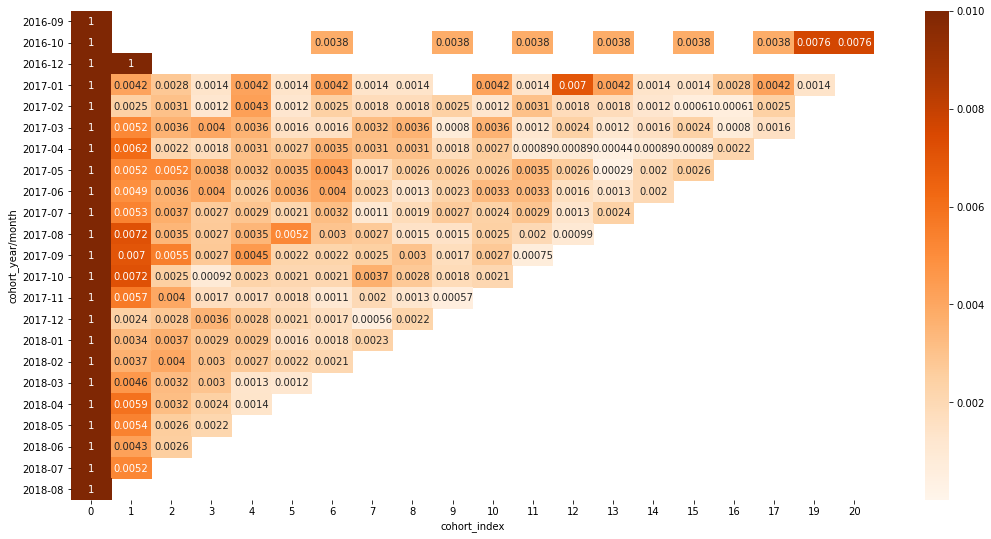

In [109]:
plt.figure(figsize=(18,9))

sns.heatmap(ret_rate, annot=True, vmin=0.00001, vmax=0.01, cmap='Oranges')

#### Когорта с самым высоким retention на 3й месяц  - cohort_year/month=2017-03,      retention=0.003997

_

### Используя python, построй RFM-сегментацию пользователей, чтобы качественно оценить свою аудиторию.

Сделаем RFM-сегментацию - поведение клиентов по трем параметрам:
    
    recency: насколько недавней является последняя покупка клиента.
    frequency: как часто клиент совершает покупку.
    monetary: сколько денег тратит клиент.
    

In [110]:
#   объединим таблицы покупатели и чеки (нужные колонки)
#   будем считать, что заказ относится к месяцу в котором он сделан (order_purchase_timestamp)

cust_orders = pd.merge(customers.drop(columns=['customer_zip_code_prefix', \
                                               'customer_city', \
                                               'customer_state']), 
                       orders.drop(columns=['order_approved_at', \
                                            'order_delivered_carrier_date', \
                                            'order_delivered_customer_date', \
                                            'order_estimated_delivery_date']), 
                       on = ['customer_id'])

In [111]:
#  воспользуемся таблицей с прошлого шага: пользователи и дата заказа
cust_orders.head()

,customer_id,customer_unique_id,order_id,order_status,order_purchase_timestamp,purchase_year,purchase_month
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,00e7ee1b050b8499577073aeb2a297a1,delivered,2017-05-16 15:05:35,2017,5
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,29150127e6685892b6eab3eec79f59c7,delivered,2018-01-12 20:48:24,2018,1
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,b2059ed67ce144a36e2aa97d2c9e9ad2,delivered,2018-05-19 16:07:45,2018,5
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,951670f92359f4fe4a63112aa7306eba,delivered,2018-03-13 16:06:38,2018,3
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,6b7d50bd145f6fc7f33cebabd7e49d0f,delivered,2018-07-29 09:51:30,2018,7


In [112]:
# только совершенные покупки
cust_orders = cust_orders.query('order_status == "delivered"')

In [113]:
# за 
import datetime

fin_day = cust_orders.order_purchase_timestamp.max()+ datetime.timedelta(days=1)

In [114]:
fin_day

Timestamp('2018-08-30 15:00:37')

In [115]:
#  посмотрим когда была последняя покупка у каждого пользователя

In [116]:
last_order = cust_orders.groupby('customer_unique_id',as_index=False).agg(last_order=('order_purchase_timestamp','max'))

In [117]:
last_order.head()

,customer_unique_id,last_order
0,0000366f3b9a7992bf8c76cfdf3221e2,2018-05-10 10:56:27
1,0000b849f77a49e4a4ce2b2a4ca5be3f,2018-05-07 11:11:27
2,0000f46a3911fa3c0805444483337064,2017-03-10 21:05:03
3,0000f6ccb0745a6a4b88665a16c9f078,2017-10-12 20:29:41
4,0004aac84e0df4da2b147fca70cf8255,2017-11-14 19:45:42


In [118]:
#   добавим этот столбик основной таблице
cust_orders = cust_orders.merge(last_order, how='inner', on='customer_unique_id')

In [119]:
cust_orders.head()

,customer_id,customer_unique_id,order_id,order_status,order_purchase_timestamp,purchase_year,purchase_month,last_order
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,00e7ee1b050b8499577073aeb2a297a1,delivered,2017-05-16 15:05:35,2017,5,2017-05-16 15:05:35
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,29150127e6685892b6eab3eec79f59c7,delivered,2018-01-12 20:48:24,2018,1,2018-01-12 20:48:24
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,b2059ed67ce144a36e2aa97d2c9e9ad2,delivered,2018-05-19 16:07:45,2018,5,2018-05-19 16:07:45
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,951670f92359f4fe4a63112aa7306eba,delivered,2018-03-13 16:06:38,2018,3,2018-03-13 16:06:38
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,6b7d50bd145f6fc7f33cebabd7e49d0f,delivered,2018-07-29 09:51:30,2018,7,2018-07-29 09:51:30


In [120]:
cust_orders.shape

(96478, 8)

In [121]:
# смотрим сколько дней разрыв между последней покупкой и  fin_day
cust_orders['Days Since Order'] = (fin_day - cust_orders['last_order'])

In [122]:
cust_orders.head()

,customer_id,customer_unique_id,order_id,order_status,order_purchase_timestamp,purchase_year,purchase_month,last_order,Days Since Order
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,00e7ee1b050b8499577073aeb2a297a1,delivered,2017-05-16 15:05:35,2017,5,2017-05-16 15:05:35,470 days 23:55:02
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,29150127e6685892b6eab3eec79f59c7,delivered,2018-01-12 20:48:24,2018,1,2018-01-12 20:48:24,229 days 18:12:13
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,b2059ed67ce144a36e2aa97d2c9e9ad2,delivered,2018-05-19 16:07:45,2018,5,2018-05-19 16:07:45,102 days 22:52:52
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,951670f92359f4fe4a63112aa7306eba,delivered,2018-03-13 16:06:38,2018,3,2018-03-13 16:06:38,169 days 22:53:59
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,6b7d50bd145f6fc7f33cebabd7e49d0f,delivered,2018-07-29 09:51:30,2018,7,2018-07-29 09:51:30,32 days 05:09:07


In [123]:
# таблица "покупатель"-"сколько дней с последней покупки"
recency = cust_orders.groupby('customer_unique_id', as_index=False) \
                     .agg({'Days Since Order':'min'})

In [124]:
recency.head()

,customer_unique_id,Days Since Order
0,0000366f3b9a7992bf8c76cfdf3221e2,112 days 04:04:10
1,0000b849f77a49e4a4ce2b2a4ca5be3f,115 days 03:49:10
2,0000f46a3911fa3c0805444483337064,537 days 17:55:34
3,0000f6ccb0745a6a4b88665a16c9f078,321 days 18:30:56
4,0004aac84e0df4da2b147fca70cf8255,288 days 19:14:55


In [125]:
recency.shape

(93358, 2)

In [126]:
#    таблица "покупатель"-"количество покупок за весь период"
frequency = cust_orders.groupby('customer_unique_id', as_index=False) \
                        .agg({'order_id':'count'}) \
                        .sort_values('order_id')

In [127]:
frequency.tail()

,customer_unique_id,order_id
73921,ca77025e7201e3b30c44b472ff346268,7
36706,6469f99c1f9dfae7733b25662e7f1782,7
10060,1b6c7548a2a1f9037c1fd3ddfed95f33,7
22779,3e43e6105506432c953e165fb2acf44c,9
51431,8d50f5eadf50201ccdcedfb9e2ac8455,15


In [128]:
frequency.shape

(93358, 2)

In [129]:
#    создадим таблицу с общей суммой  каждого чека у покупателя
#    сначала присоеденим к элементам заказа customer_id и статус заказа

In [130]:
sum_orders = pd.merge(order_items.drop(columns=['product_id','seller_id', \
                                               'shipping_limit_date', \
                                               'freight_value']), 
                       orders.drop(columns=['order_approved_at', \
                                            'order_delivered_carrier_date', \
                                            'order_delivered_customer_date', \
                                            'order_purchase_timestamp',\
                                            'order_estimated_delivery_date']), 
                       on = ['order_id'])

In [131]:
sum_orders.head()

,order_id,order_item_id,price,day,customer_id,order_status,purchase_year,purchase_month
0,00010242fe8c5a6d1ba2dd792cb16214,1,58.90,Tuesday,3ce436f183e68e07877b285a838db11a,delivered,2017,9
1,00018f77f2f0320c557190d7a144bdd3,1,239.90,Wednesday,f6dd3ec061db4e3987629fe6b26e5cce,delivered,2017,4
2,000229ec398224ef6ca0657da4fc703e,1,199.00,Thursday,6489ae5e4333f3693df5ad4372dab6d3,delivered,2018,1
3,00024acbcdf0a6daa1e931b038114c75,1,12.99,Wednesday,d4eb9395c8c0431ee92fce09860c5a06,delivered,2018,8
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,199.90,Monday,58dbd0b2d70206bf40e62cd34e84d795,delivered,2017,2


In [132]:
#    посчитаем общую сумму для каждого customer_id
sum_orders = sum_orders.query('order_status == "delivered"') \
                        .groupby(['customer_id'], as_index=False) \
                        .agg({'price':'sum'})

In [133]:
sum_orders.head()

,customer_id,price
0,00012a2ce6f8dcda20d059ce98491703,89.80
1,000161a058600d5901f007fab4c27140,54.90
2,0001fd6190edaaf884bcaf3d49edf079,179.99
3,0002414f95344307404f0ace7a26f1d5,149.90
4,000379cdec625522490c315e70c7a9fb,93.00


In [134]:
sum_orders.shape

(96478, 2)

In [135]:
#   присоеденим к customer_id данные о реальном покупателе customer_unique_id

sum_orders = pd.merge(sum_orders, cust_orders.drop(columns=['order_id', \
                                                            'order_status', \
                                                            'order_purchase_timestamp', \
                                                            'last_order', \
                                                            'Days Since Order']), 
                                   on = ['customer_id'])

In [136]:
sum_orders.head()

,customer_id,price,customer_unique_id,purchase_year,purchase_month
0,00012a2ce6f8dcda20d059ce98491703,89.80,248ffe10d632bebe4f7267f1f44844c9,2017,11
1,000161a058600d5901f007fab4c27140,54.90,b0015e09bb4b6e47c52844fab5fb6638,2017,7
2,0001fd6190edaaf884bcaf3d49edf079,179.99,94b11d37cd61cb2994a194d11f89682b,2017,2
3,0002414f95344307404f0ace7a26f1d5,149.90,4893ad4ea28b2c5b3ddf4e82e79db9e6,2017,8
4,000379cdec625522490c315e70c7a9fb,93.00,0b83f73b19c2019e182fd552c048a22c,2018,4


In [137]:
# ничего не потеряно
sum_orders.shape

(96478, 5)

In [138]:
#    сделаем таблицу customer_unique_id и сумма всех заказов за весь период
monetary = sum_orders.groupby("customer_unique_id", as_index=False) \
                     .agg({'price':'sum'})

In [139]:
monetary.head()

,customer_unique_id,price
0,0000366f3b9a7992bf8c76cfdf3221e2,129.90
1,0000b849f77a49e4a4ce2b2a4ca5be3f,18.90
2,0000f46a3911fa3c0805444483337064,69.00
3,0000f6ccb0745a6a4b88665a16c9f078,25.99
4,0004aac84e0df4da2b147fca70cf8255,180.00


In [140]:
# количество строк(customer_unique_id) такое же как и в двух предыдущих таблицах : recency, frequency
monetary.shape

(93358, 2)

Всё готово к кластеризации

recency: насколько недавней является последняя покупка клиента. Чем ближе к "настоящему", тем лучше: 5-4-3-2-1
        
frequency: как часто клиент совершает покупку. Чем чаще , тем лучше: 1-2-3-4-5
        
monetary: сколько денег тратит клиент. Чем чаще , тем лучше: 1-2-3-4-5

In [141]:
#  5-4-3-2-1 : так как у нас данные всего за 2 года, мыможем рассмотреть весь период "жизни" магазина
# категорию 5 присвоим покупкам "не старше" 3-х месяцев, кат.4 "не старше" полугода,... кат.1 все что было дальше года

recency['recency'] = pd.cut(recency['Days Since Order'], \
       pd.to_timedelta(['0 day','90 days', '180 days', '270 days', '365 days','1000 days']), \
       labels=['5','4','3','2', '1'])

In [142]:
recency

,customer_unique_id,Days Since Order,recency
0,0000366f3b9a7992bf8c76cfdf3221e2,112 days 04:04:10,4
1,0000b849f77a49e4a4ce2b2a4ca5be3f,115 days 03:49:10,4
2,0000f46a3911fa3c0805444483337064,537 days 17:55:34,1
3,0000f6ccb0745a6a4b88665a16c9f078,321 days 18:30:56,2
4,0004aac84e0df4da2b147fca70cf8255,288 days 19:14:55,2
...,...,...,...
93353,fffcf5a5ff07b0908bd4e2dbc735a684,447 days 18:00:01,1
93354,fffea47cd6d3cc0a88bd621562a9d061,262 days 18:52:41,3
93355,ffff371b4d645b6ecea244b27531430a,568 days 23:11:21,1
93356,ffff5962728ec6157033ef9805bacc48,119 days 23:42:56,4


In [143]:
# посмотрим на frequency (кол-во покупок в магазине клиентом)

frequency.order_id.unique()

array([ 1,  2,  3,  4,  5,  6,  7,  9, 15])

In [144]:
#  Пусть   кат.1: 1 покупка, кат.2: 2-3 покупки,  кат.3: 4-5 покупки, кат.4: 6-7 покупки, кат.5: > 8 покупок

In [145]:
frequency['frequency'] = pd.cut(frequency['order_id'], \
                                           [0,1,3,5,7,20], \
                                           labels=['1','2','3','4','5'])

In [146]:
frequency

,customer_unique_id,order_id,frequency
0,0000366f3b9a7992bf8c76cfdf3221e2,1,1
61790,a942d415001f36acf150dca4a627f6aa,1,1
61789,a942ba2a7bed631c5d4ec4d756b9df90,1,1
61788,a942204dbe5292ccb73d3171b6d03d54,1,1
61787,a941c257a51188577ec66ddbeee21403,1,1
...,...,...,...
73921,ca77025e7201e3b30c44b472ff346268,7,4
36706,6469f99c1f9dfae7733b25662e7f1782,7,4
10060,1b6c7548a2a1f9037c1fd3ddfed95f33,7,4
22779,3e43e6105506432c953e165fb2acf44c,9,5


In [147]:
# деление monetary на категории

In [148]:
monetary.price.describe()

count    93358.000000
mean       141.621480
std        215.694014
min          0.850000
25%         47.650000
50%         89.730000
75%        154.737500
max      13440.000000
Name: price, dtype: float64

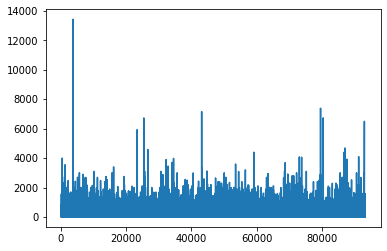

In [149]:
monetary.price.plot()

In [150]:
# кат.1 - до 25%
# кат.2 -  25%-50%
# кат.3 -  50%-75%
# кат.4 -  75%-1000$
# кат.5 -  от 1000$ (потому что довольна большая покупка, таких клиентов надо отслеживать отдельно)

monetary['monetary'] = pd.cut(monetary['price'], \
                                [0, 47.65, 89.73, 154.7375, 1000, 200000], \
                                labels=['1','2','3','4','5'])

In [151]:
monetary.head()

,customer_unique_id,price,monetary
0,0000366f3b9a7992bf8c76cfdf3221e2,129.90,3
1,0000b849f77a49e4a4ce2b2a4ca5be3f,18.90,1
2,0000f46a3911fa3c0805444483337064,69.00,2
3,0000f6ccb0745a6a4b88665a16c9f078,25.99,1
4,0004aac84e0df4da2b147fca70cf8255,180.00,4


In [152]:
monetary.isna().sum()

customer_unique_id    0
price                 0
monetary              0
dtype: int64

In [153]:
#   объеденяем три таблицы в одну
rfm = recency.merge(frequency, on='customer_unique_id') \
             .merge(monetary, on='customer_unique_id')

In [154]:
rfm = rfm.drop(columns=['Days Since Order','order_id','price'])

In [155]:
rfm

,customer_unique_id,recency,frequency,monetary
0,0000366f3b9a7992bf8c76cfdf3221e2,4,1,3
1,0000b849f77a49e4a4ce2b2a4ca5be3f,4,1,1
2,0000f46a3911fa3c0805444483337064,1,1,2
3,0000f6ccb0745a6a4b88665a16c9f078,2,1,1
4,0004aac84e0df4da2b147fca70cf8255,2,1,4
...,...,...,...,...
93353,fffcf5a5ff07b0908bd4e2dbc735a684,1,1,5
93354,fffea47cd6d3cc0a88bd621562a9d061,3,1,2
93355,ffff371b4d645b6ecea244b27531430a,1,1,3
93356,ffff5962728ec6157033ef9805bacc48,4,1,3


In [156]:
rfm.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 93358 entries, 0 to 93357
Data columns (total 4 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   customer_unique_id  93358 non-null  object  
 1   recency             93358 non-null  category
 2   frequency           93358 non-null  category
 3   monetary            93358 non-null  category
dtypes: category(3), object(1)
memory usage: 1.7+ MB


In [157]:
rfm.query('recency == "4" and frequency == "4" and monetary == "4"')

,customer_unique_id,recency,frequency,monetary
36500,63cfc61cee11cbe306bff5857d00bfe4,4,4,4
73921,ca77025e7201e3b30c44b472ff346268,4,4,4
87885,f0e310a6839dce9de1638e0fe5ab282a,4,4,4


In [158]:
rfm.query('recency in ("4","5") and frequency in ("4","5") and monetary in ("4","5")')

,customer_unique_id,recency,frequency,monetary
36500,63cfc61cee11cbe306bff5857d00bfe4,4,4,4
36706,6469f99c1f9dfae7733b25662e7f1782,5,4,4
51431,8d50f5eadf50201ccdcedfb9e2ac8455,5,5,4
73921,ca77025e7201e3b30c44b472ff346268,4,4,4
80538,dc813062e0fc23409cd255f7f53c7074,5,4,4
87885,f0e310a6839dce9de1638e0fe5ab282a,4,4,4


    Покупатели которые сделали больше 5 покупок, 
    были не позднее полугода "назад", 
    и потратили от 150 до  1000$ в процессе...